In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools

In [2]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # can be chaged depending on dataset

# trainig config
epochs = 16
batch_size= 128

In [3]:
# https://www.kaggel.com/moltean/fruits
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip

--2023-07-19 19:43:51--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  18.0MB/s    in 15s     

2023-07-19 19:44:07 (12.3 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [4]:
!unzip -nq fruits-360.zip

In [5]:
# declaring paths
train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

In [6]:
# useful for gettinng number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [7]:
# useful for getting number of classes
folders = glob(train_path + '/*')

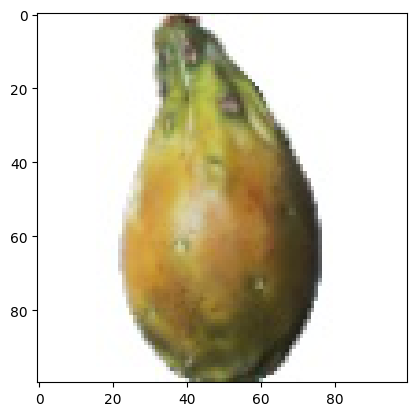

In [8]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)));

In [9]:
# instiate ResNet50
res = ResNet50(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False
)

94765736/94765736 [==============================] - 4s 0us/step


In [10]:
# dont train existing weights
for layer in res.layers:
  layer.trainable = False

In [11]:
# our layers - can add more i needed
x = Flatten()(res.output)
# x = Dense(1000, activation='relu)(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

In [12]:
# create a model object
model = Model(inputs=res.input, outputs=prediction)

In [13]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [14]:
# tell the model what cost and optimization method to use
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [16]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

min: -99.939 max: 151.061


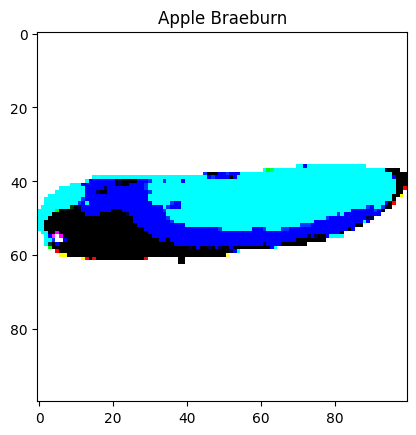

In [17]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0].max())])
  plt.imshow(x[0])
  plt.show()
  break

In [18]:
# create generators
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=batch_size,
    class_mode='sparse',
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [19]:
# fit the model
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/16
224/224 [==============================] - 120s 477ms/step - loss: 0.5870 - accuracy: 0.9209 - val_loss: 0.1626 - val_accuracy: 0.9643
Epoch 2/16
224/224 [==============================] - 104s 465ms/step - loss: 0.1171 - accuracy: 0.9804 - val_loss: 0.2040 - val_accuracy: 0.9735
Epoch 3/16
224/224 [==============================] - 104s 465ms/step - loss: 0.1356 - accuracy: 0.9822 - val_loss: 0.1694 - val_accuracy: 0.9735
Epoch 4/16
224/224 [==============================] - 106s 474ms/step - loss: 0.1349 - accuracy: 0.9839 - val_loss: 0.1333 - val_accuracy: 0.9821
Epoch 5/16
224/224 [==============================] - 106s 473ms/step - loss: 0.1136 - accuracy: 0.9868 - val_loss: 0.3790 - val_accuracy: 0.9745
Epoch 6/16
224/224 [==============================] - 104s 462ms/step - loss: 0.0883 - accuracy: 0.9898 - val_loss: 0.4327 - val_accuracy: 0.9651
Epoch 7/16
224/224 [==============================] - 106s 472ms/step - loss: 0.0986 - accuracy: 0.9898 - val_loss: 0.2334 -

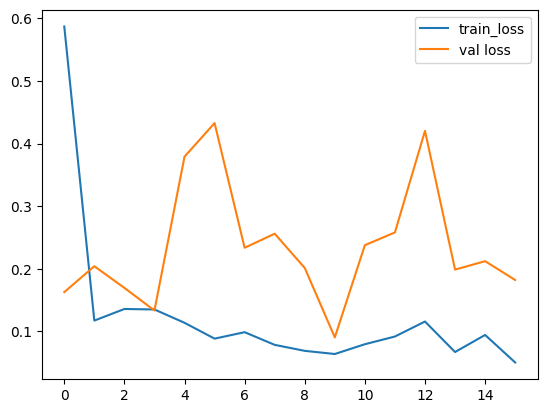

In [20]:
# loss
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

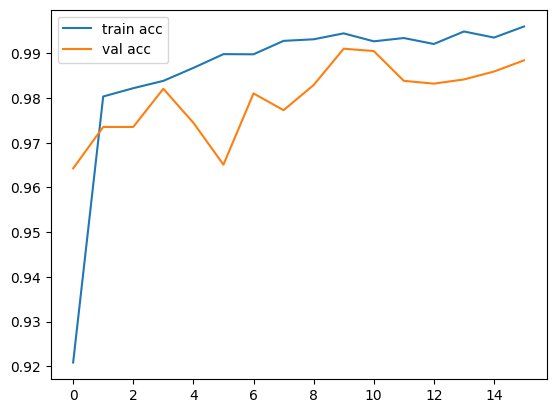

In [21]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

In [27]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print('Generatin confusion matirx', N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size=IMAGE_SIZE,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images proceeded.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions,p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [23]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generatin confusion matirx 9673
Found 9673 images belonging to 60 classes.
7/7 [==============================] - 1s 101ms/step
[[163   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 159 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 157]]


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting "normalize=True".
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, whitout normalization")

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment='center',
              color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()





In [ ]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

Confusion matrix, whitout normalization
[[163   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 159 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 157]]


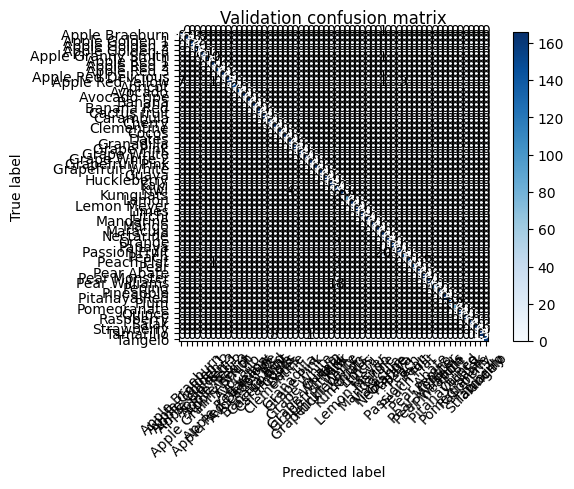

In [28]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [ ]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
import os

def mkdir(p):
  if not os.path.exists(p):
    os.mkdir(p)

def link(src, dst):
  if not os.path.exists(dst):
    os.symlink(src, dst, target_is_directory=True)

mkdir('../large_files/fruits-360-small')


classes = [
  'Apple Golden 1',
  'Avocado',
  'Lemon',
  'Mango',
  'Kiwi',
  'Banana',
  'Strawberry',
  'Raspberry'
]

train_path_from = os.path.abspath('../large_files/fruits-360/Training')
valid_path_from = os.path.abspath('../large_files/fruits-360/Validation')

train_path_to = os.path.abspath('../large_files/fruits-360-small/Training')
valid_path_to = os.path.abspath('../large_files/fruits-360-small/Validation')

mkdir(train_path_to)
mkdir(valid_path_to)


for c in classes:
  link(train_path_from + '/' + c, train_path_to + '/' + c)
  link(valid_path_from + '/' + c, valid_path_to + '/' + c)

In [ ]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

# https://www.kaggle.com/paultimothymooney/blood-cells
# train_path = '../large_files/blood_cell_images/TRAIN'
# valid_path = '../large_files/blood_cell_images/TEST'

# https://www.kaggle.com/moltean/fruits
train_path = '../large_files/fruits-360/Training'
valid_path = '../large_files/fruits-360/Validation'
# train_path = '../large_files/fruits-360-small/Training'
# valid_path = '../large_files/fruits-360-small/Validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')


# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()


# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)



def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')